In [1]:
import pandas as pd

colunas = ['PROCESSO', 'ROTULO_MANUAL', 'LEI']

df = pd.read_csv('../data/leis.csv', header=0, sep=',', quotechar='"', usecols=colunas)

In [2]:
 df.head()

,PROCESSO,ROTULO_MANUAL,LEI
0,00039604720138240039,CDC,artigo 535
1,00039604720138240039,CDC,9656/1998
2,00039604720138240039,CDC,616/2012
3,00039604720138240039,CDC,artigo 535
4,00039604720138240039,CDC,9656/1998


Utitiza apenas label que contenham mais de 200 exemplos.

In [4]:
rotulos = ['EXP', 'BAN', 'OIG', 'DAN', 'SEG', 'CON', 'OIE']

df.loc[~df['ROTULO_MANUAL'].isin(rotulos), 'ROTULO_MANUAL'] = 'NONE'

In [5]:
groupby_rotulo = df.groupby('ROTULO_MANUAL')

groupby_rotulo[['LEI']].count().sort_values(['LEI'], ascending=False)

,LEI
ROTULO_MANUAL,
NONE,7438
EXP,7204
OIG,3165
BAN,2787
DAN,1836
SEG,1816
CON,1655
OIE,913


In [6]:
df.shape

(26814, 3)

In [7]:
data = df.groupby(['PROCESSO', 'ROTULO_MANUAL', 'LEI']).size().unstack('LEI', fill_value=0)
data = data.reset_index()

data.head()

LEI,PROCESSO,ROTULO_MANUAL,1/1975,1/2012,100/2015,101/2010,10144/2002,10150/2000,1025/2009,10257/2001,...,artigo 957,artigo 962,artigo 966,artigo 975,artigo 98,artigo 982,artigo 99,artigo 991,artigo 996,artigo 998
0,00000042920148240058,CON,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,00000057320168240242,NONE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00000110319958240053,NONE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00000186020108240023,NONE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00000224520138240071,OIG,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y = data['ROTULO_MANUAL'].values
y.shape

(3260,)

In [9]:
df1 = data.iloc[:,2:].copy()
df1.head()

LEI,1/1975,1/2012,100/2015,101/2010,10144/2002,10150/2000,1025/2009,10257/2001,104/1990,1060/1950,...,artigo 957,artigo 962,artigo 966,artigo 975,artigo 98,artigo 982,artigo 99,artigo 991,artigo 996,artigo 998
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
x = df1.values
x.shape

(3260, 713)

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

import collections

print(collections.Counter(y_train))
print(collections.Counter(y_test))

Counter({'NONE': 759, 'EXP': 339, 'OIG': 283, 'BAN': 273, 'SEG': 225, 'DAN': 190, 'OIE': 189, 'CON': 187})
Counter({'NONE': 256, 'EXP': 113, 'OIG': 97, 'BAN': 94, 'SEG': 90, 'DAN': 60, 'CON': 60, 'OIE': 45})


In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

text_clf = Pipeline([
    ('clf', clf)
])

text_clf.fit(x , y)

Pipeline(memory=None,
     steps=[('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])

Testando o modelo.

In [13]:
y_pred = text_clf.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.8478527607361963

In [14]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         BAN       0.84      0.84      0.84        94
         CON       0.87      0.75      0.80        60
         DAN       0.86      0.72      0.78        60
         EXP       0.89      0.93      0.91       113
        NONE       0.77      0.93      0.84       256
         OIE       0.87      0.60      0.71        45
         OIG       0.94      0.92      0.93        97
         SEG       1.00      0.71      0.83        90

   micro avg       0.85      0.85      0.85       815
   macro avg       0.88      0.80      0.83       815
weighted avg       0.86      0.85      0.85       815



In [15]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)

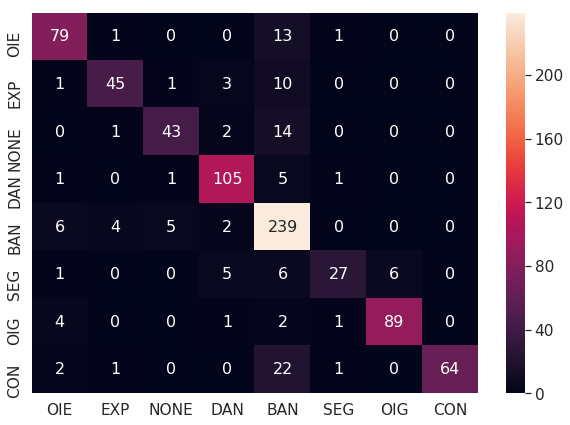

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = set(y_test)
      
df_cm = pd.DataFrame(cnf_matrix, range(len(labels)), range(len(labels)))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='g', annot_kws={"size": 16})

In [18]:
features = list(data.columns.values)
del features[0:2]

len(features)

713

In [28]:
df_sample = pd.DataFrame(columns=features)
df_sample = df_sample.append({'artigo 1018': 1}, ignore_index=True)
df_sample = df_sample.fillna(0)

df_sample

,1/1975,1/2012,100/2015,101/2010,10144/2002,10150/2000,1025/2009,10257/2001,104/1990,1060/1950,...,artigo 957,artigo 962,artigo 966,artigo 975,artigo 98,artigo 982,artigo 99,artigo 991,artigo 996,artigo 998
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
y_pred = text_clf.predict(df_sample)

y_pred

array(['EXP'], dtype=object)

In [25]:
from sklearn.externals import joblib

joblib.dump(features, '../modelos/Features-Leis.pkl', compress = 1)
joblib.dump(clf, '../modelos/Modelo-Leis.pkl', compress = 1) 

['../modelos/Modelo-Leis.pkl']